In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

In [2]:
datos = pd.read_csv('events.csv', low_memory= False)
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011288 entries, 0 to 1011287
Data columns (total 23 columns):
timestamp                   1011288 non-null object
event                       1011288 non-null object
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null object
storage                     563836 non-null object
color                       563836 non-null object
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null object
campaign_source             82796 non-null object
search_engine               50957 non-null object
channel                     87378 non-null object
new_vs_returning            87378 non-null object
city                        87378 non-null object
region                    

#### Paso "sku" a numérico porque algunos registros tenían mismo valor pero distinto tipo e.g. 1090 y 1090.0

In [3]:
datos = datos.sort_values(by=['person', 'timestamp'], ascending=True)
datos["sku"] = pd.to_numeric(datos["sku"], errors="coerce")

#### Creo el DF de los productos 

In [4]:
productos = datos[["sku", "model", "condition", "storage", "color", "event"]].dropna(subset=["sku"])
productos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563836 entries, 2 to 1011287
Data columns (total 6 columns):
sku          563836 non-null float64
model        563836 non-null object
condition    563836 non-null object
storage      563836 non-null object
color        563836 non-null object
event        563836 non-null object
dtypes: float64(1), object(5)
memory usage: 30.1+ MB


In [5]:
productos_comprados = productos.loc[productos['event'] == "checkout"]
productos_vistos = productos.loc[productos['event'] == "viewed product"]

# Análisis exploratorio

## Overview del set de datos

In [6]:
datos.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(datos.shape)

(1011288, 23)


In [8]:
datos.isnull().sum()

timestamp                         0
event                             0
person                            0
url                          928532
sku                          447452
model                        447004
condition                    447452
storage                      447452
color                        447452
skus                         789589
search_term                  962321
staticpage                  1007690
campaign_source              928492
search_engine                960331
channel                      923910
new_vs_returning             923910
city                         923910
region                       923910
country                      923910
device_type                  923910
screen_resolution            923910
operating_system_version     923910
browser_version              923910
dtype: int64

##### Muchos nulos. 'staticpage' tiene casi todos nulos. No aporta nada de información

#### Eventos

In [9]:
for x in datos['event'].unique():
    print (x)

ad campaign hit
visited site
viewed product
checkout
generic listing
search engine hit
brand listing
searched products
conversion
staticpage
lead


#### Condiciones en las que puede encontrarse un producto

In [10]:
for x in datos['condition'].unique():
    print (x)

nan
Bom
Muito Bom
Excelente
Bom - Sem Touch ID
Novo


In [11]:
# Las pasamos a español para que las visualizaciones se vean en español
datos.loc[datos['condition'] == 'Bom', 'condition'] = 'Bien'
datos.loc[datos['condition'] == 'Muito Bom', 'condition'] = 'Muy Bien'
datos.loc[datos['condition'] == 'Bom - Sem Touch ID', 'condition'] = 'Bien - Sin Touch ID'
datos.loc[datos['condition'] == 'Novo', 'condition'] = 'Nuevo'

## Visualizaciones

### 1. Las empresas publicitarias que más vistas generan

In [12]:
# Cantidad de eventos por campañas publicitarias
datos_campaign_source = datos['campaign_source'].value_counts()
datos_campaign_source
datos.groupby('campaign_source').agg({'campaign_source':'count'}).sort_values('campaign_source',ascending=False)\
                .rename(columns={"campaign_source": "Cantidad de visitas"})

,Cantidad de visitas
campaign_source,
google,58153
criteo,9694
rtbhouse,8550
zanox,1673
emblue,1352
FacebookAds,764
afilio,692
bing,484
voxus,432


Text(0,0.5,'Cantidad de avisos')

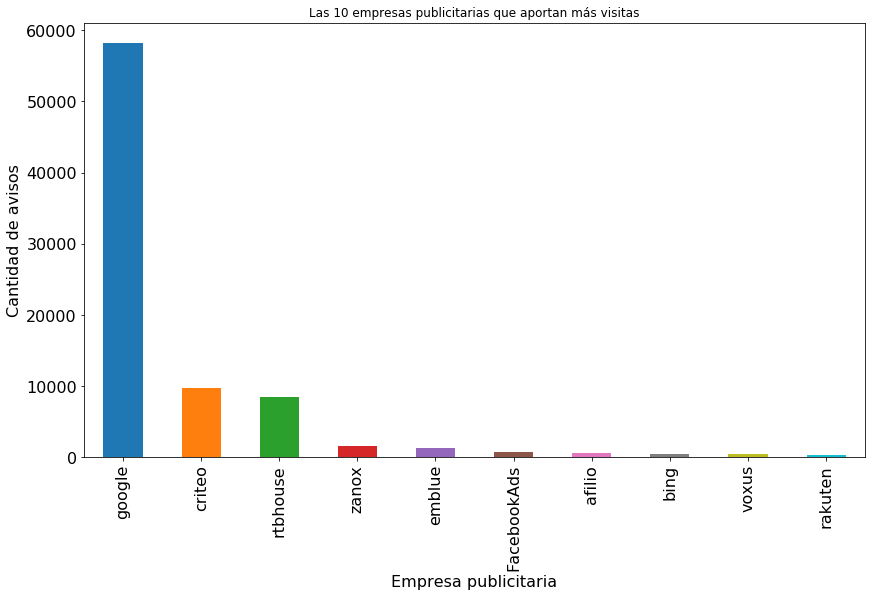

In [13]:
fig =plt.figure()
ax = datos_campaign_source[:10].plot('bar', figsize=(14,8), title='Las 10 empresas publicitarias que aportan más visitas', fontsize=16)
ax.set_xlabel('Empresa publicitaria',fontsize=16)
ax.set_ylabel('Cantidad de avisos',fontsize=16)

### 2. Modelos más visitados

Text(0,0.5,'Modelo')

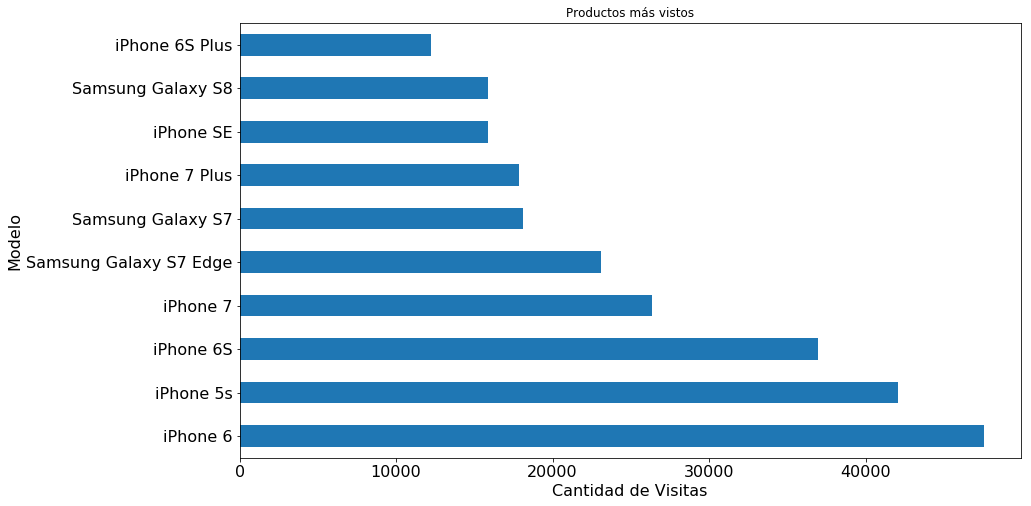

In [14]:
productos_vistos_cantidad_plot = productos_vistos[['model','event']].groupby(['model']).count()\
            .sort_values('event', ascending = False).head(10).plot(kind='barh',fontsize=16, figsize=(14,8)\
            ,rot=0, title='Productos más vistos', legend=None)
productos_vistos_cantidad_plot.set_xlabel("Cantidad de Visitas", fontsize=16)
productos_vistos_cantidad_plot.set_ylabel("Modelo", fontsize=16)

##### Los teléfonos más buscados son los iphone y los samsung

### 3. Modelos más comprados 

Text(0,0.5,'Modelo')

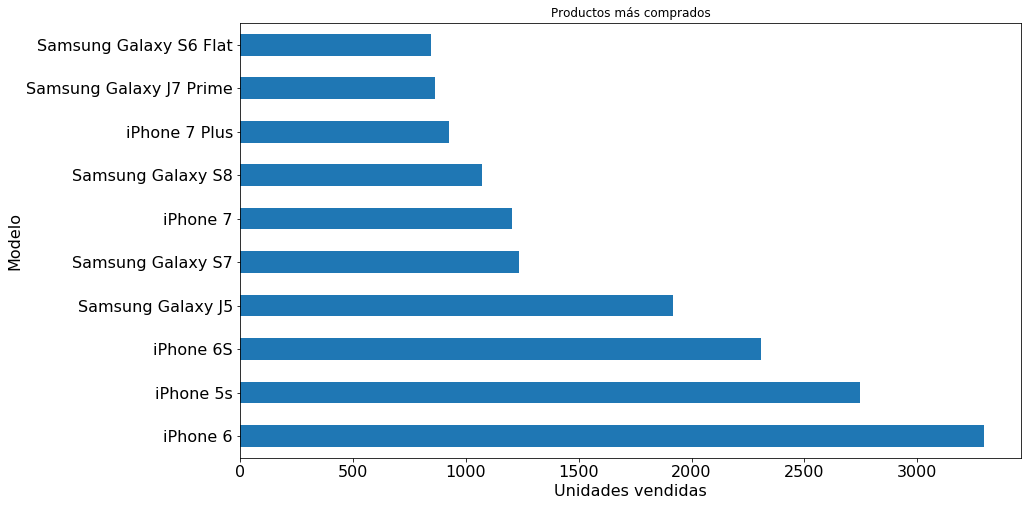

In [15]:
productos_comprados_cantidad_plot = productos_comprados[['model','event']].groupby(['model']).count()\
        .sort_values('event', ascending = False).head(10).plot(kind='barh',fontsize=16, figsize=(14,8), rot=0\
        , title='Productos más comprados', legend=None)
productos_comprados_cantidad_plot.set_xlabel("Unidades vendidas", fontsize=16)
productos_comprados_cantidad_plot.set_ylabel("Modelo", fontsize=16)

##### Los teléfonos más comprados son los iphone, seguidos por los samsung

### 4. Estado de los productos más comprados

Text(0,0.5,'Modelo')

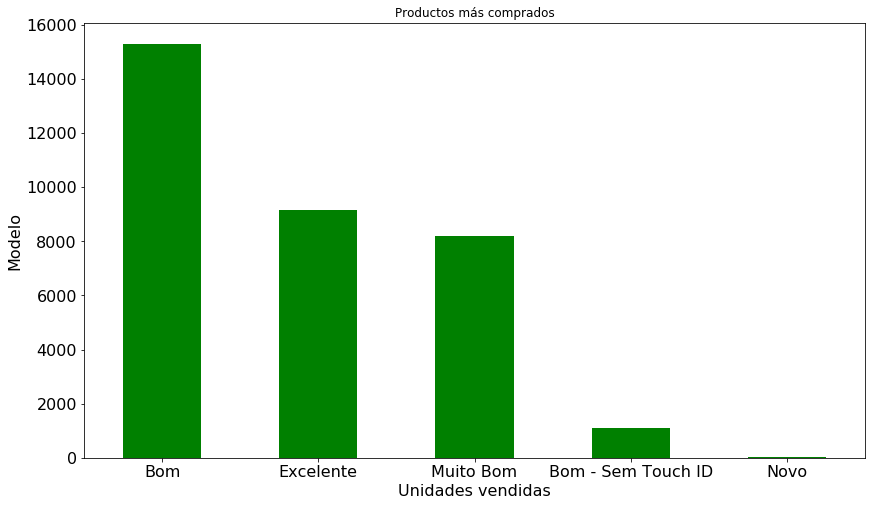

In [16]:
productos_comprados_estado_plot = productos_comprados[['condition','event']].groupby(['condition']).count()\
        .sort_values('event', ascending = False).head(10).plot(kind='bar',fontsize=16, figsize=(14,8), rot=0\
        ,color="green", title='Productos más comprados', legend=None)
productos_comprados_estado_plot.set_xlabel("Unidades vendidas", fontsize=16)
productos_comprados_estado_plot.set_ylabel("Modelo", fontsize=16)

##### La gente no le da tanta importancia al estado del teléfono

### 5. Estado de los productos más visitiados

Text(0,0.5,'Modelo')

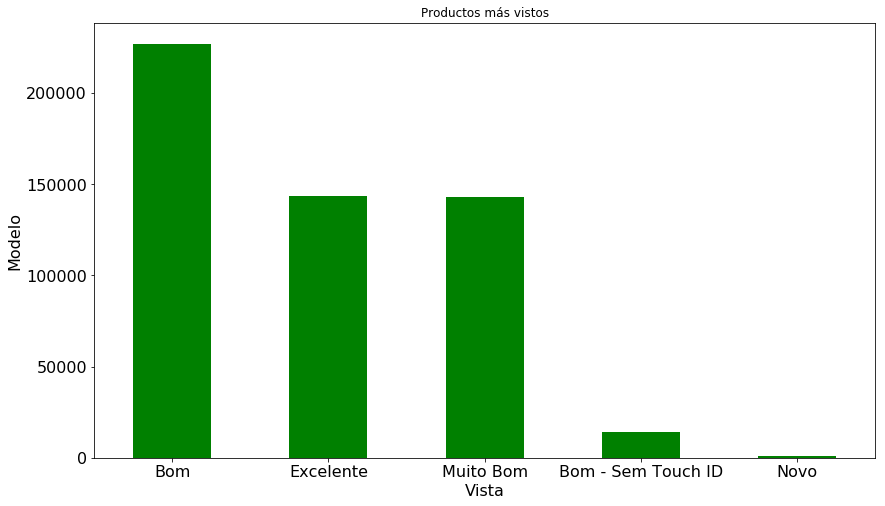

In [17]:
productos_vistos_estado_plot = productos_vistos[['condition','event']].groupby(['condition']).count()\
        .sort_values('event', ascending = False).head(10).plot(kind='bar',fontsize=16, figsize=(14,8), rot=0\
        ,color="green", title='Productos más vistos', legend=None)
productos_vistos_estado_plot.set_xlabel("Vista", fontsize=16)
productos_vistos_estado_plot.set_ylabel("Modelo", fontsize=16)

##### La gente no le da tanta importancia al estado del teléfono

### 6. Proporción de productos según el estado

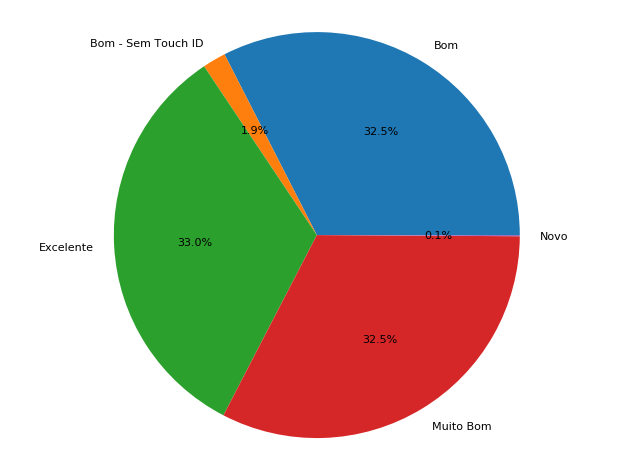

In [18]:
catalogo = productos.drop_duplicates('sku')
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
catalogo_plot = catalogo[['condition', 'event']].groupby('condition').count().reset_index()
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0) 
plt.pie(catalogo_plot['event'], labels=catalogo_plot['condition'], autopct='%1.1f%%')

plt.axis('equal')
plt.tight_layout()
plt.show()

##### Hay una proporción equilibrada de teléfonos en buen, muy buen y excelente estado. Las tendencias previamente analizadas no responden a una diferencia de oferta

##### El estado del teléfono no es tan importante

### 7. ¿A qué hora son más efectivas las publicidades?

Text(0,0.5,'Cantidad de Clicks en Publicidades')

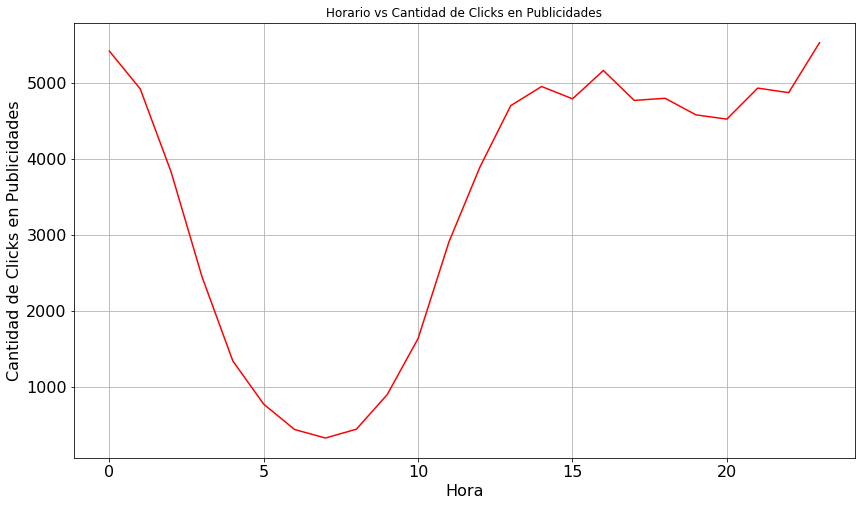

In [19]:
publicidades = datos[['timestamp', 'person']].loc[datos['event'] == 'ad campaign hit']
publicidades['timestamp'] = publicidades['timestamp'].str.split(" ").str[1].str.split(":").str[0]


publicidades_hora_plot = publicidades.groupby('timestamp').count().reset_index()\
                        .plot.line(color='red',legend=None, fontsize=16, grid=True\
                        , figsize=(14,8), rot=0 ,title='Horario vs Cantidad de Clicks en Publicidades' )
publicidades_hora_plot.set_xlabel("Hora", fontsize=16)
publicidades_hora_plot.set_ylabel("Cantidad de Clicks en Publicidades", fontsize=16)

### 8. Los eventos que derivan en una compra

##### Para realizar este análisis se creó un nuevo dataframe de "Sesiones" llamado "flujo_compra". Una sesión registra los movimientos de un usuario en un período de una hora. Se consideró que como máximo una sesión puede durar una hora, es decir que si un usuario entra a la página de trocafone en un mismo día pero en distinto horario (a la mañana y a la noche), generará dos registros distintos. Si bien solo estamos considerando el evento inicial y el final, creemos que con algunas modificaciones este dataframe puede más adelante aportar información interesante.

In [20]:
from datetime import datetime
def mostrar(df):    
    rows = []
    person = ""    
    for index, row in df.iterrows():  
        if(person == ""):
            person = row["person"]
            first_event_time = row["timestamp"]
            first_event_name = row["event"]
            final_event_time = row["timestamp"]
            final_event_name = row["event"]                        
            continue
        if(person != row["person"] or (datetime.strptime(row['timestamp'],"%Y-%m-%d %H:%M:%S") - datetime.strptime(first_event_time,"%Y-%m-%d %H:%M:%S")).total_seconds() > 3600):                        
            rows.append([person, first_event_name, first_event_time, final_event_name, final_event_time])            
            person = row["person"]
            first_event_time = row["timestamp"]
            first_event_name = row["event"]    
            final_event_time = row["timestamp"]
            final_event_name = row["event"]                        
        else:   
            final_event_time = row["timestamp"]
            final_event_name = row["event"]                        
    return pd.DataFrame(rows,columns=('person', 'first_event', 'first_event_time', 'final_event', 'final_event_time'))

In [21]:
flujo_compra = mostrar(datos[['timestamp', 'event', 'person',]].sort_values(by=['person', 'timestamp']))

In [22]:
flujo_compra = flujo_compra.loc[flujo_compra['first_event_time'] != flujo_compra['final_event_time']]
flujo_compra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77588 entries, 0 to 86543
Data columns (total 5 columns):
person              77588 non-null object
first_event         77588 non-null object
first_event_time    77588 non-null object
final_event         77588 non-null object
final_event_time    77588 non-null object
dtypes: object(5)
memory usage: 3.6+ MB


In [23]:
termina_en_compra = flujo_compra.loc[flujo_compra['final_event']=='checkout']

Text(0,0.5,'Evento')

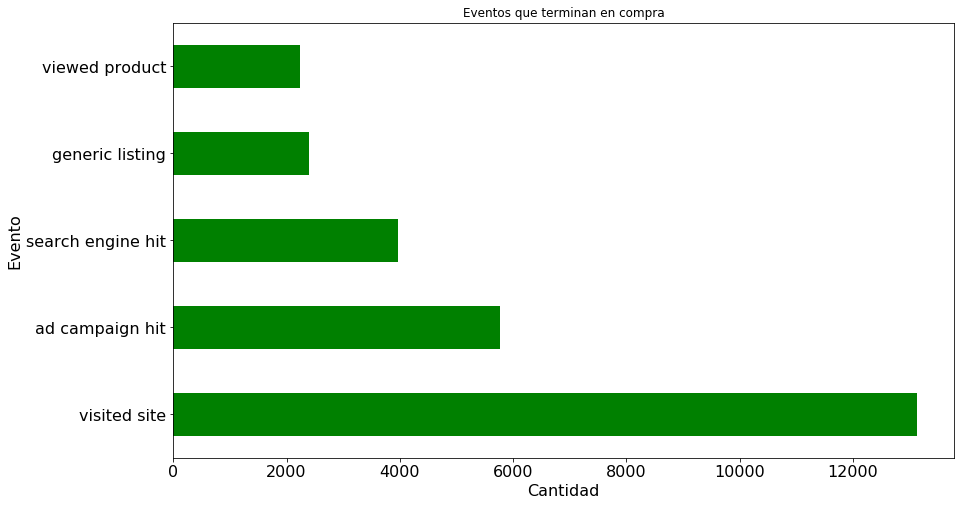

In [24]:
termina_en_compra.groupby('first_event').count()
eventos_compra_plot = termina_en_compra[['first_event','first_event_time']].groupby(['first_event']).count()\
        .sort_values('first_event_time', ascending = False).head(5).plot(kind='barh',fontsize=16, figsize=(14,8), rot=0\
        ,color="green", title='Eventos que terminan en compra', legend=None)
eventos_compra_plot.set_xlabel("Cantidad", fontsize=16)
eventos_compra_plot.set_ylabel("Evento", fontsize=16)

##### Observamos que la mitad de las ventas se llegan mediante publicidades

### 9. Registraciones de los usuarios

In [25]:
# Tomamos la fecha de registración de los usuarios
nuevos = datos.loc[datos['new_vs_returning'] == 'New']
usuarios_nuevos = nuevos[['person','timestamp']]
usuarios_nuevos.rename(columns={'timestamp':'fecha_registro'},inplace=True)
usuarios_nuevos.head(5)

,person,fecha_registro
1,0004b0a2,2018-05-31 23:38:05
5,0006a21a,2018-05-29 13:29:26
9,000a54b2,2018-04-09 20:12:31
45,00184bf9,2018-04-06 05:12:05
96,0019c395,2018-05-17 00:08:56


In [26]:
usuarios_nuevos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26898 entries, 1 to 1011284
Data columns (total 2 columns):
person            26898 non-null object
fecha_registro    26898 non-null object
dtypes: object(2)
memory usage: 630.4+ KB


[Text(0,0.5,'Lunes'),
 Text(0,1.5,'Martes'),
 Text(0,2.5,'Miercoles'),
 Text(0,3.5,'Jueves'),
 Text(0,4.5,'Viernes'),
 Text(0,5.5,'Sábado'),
 Text(0,6.5,'Domingo')]

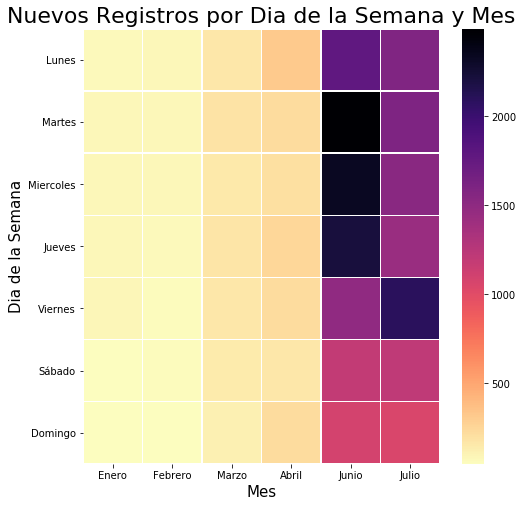

In [27]:
nuevas_registraciones = usuarios_nuevos[['person','fecha_registro']]
nuevas_registraciones['fecha_registro'] = pd.to_datetime(nuevas_registraciones['fecha_registro'])
nuevas_registraciones['Mes'] = nuevas_registraciones['fecha_registro'].dt.month
nuevas_registraciones['Dia'] = nuevas_registraciones['fecha_registro'].dt.dayofweek
nuevas_registraciones['Cantidad'] = 1
nuevas_registraciones['Mes'] = nuevas_registraciones['Mes'] - 1

Dias = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sábado','Domingo']
Meses = ['Enero','Febrero','Marzo','Abril','Junio','Julio']
nuevas_registraciones['Dia'] = nuevas_registraciones['Dia'].apply(lambda x: Dias[x])
nuevas_registraciones['Mes'] = nuevas_registraciones['Mes'].apply(lambda x: Meses[x])


table = nuevas_registraciones.pivot_table(index='Dia',columns='Mes',aggfunc=np.sum)
table.columns = table.columns.droplevel(0)
table = table[Meses]
table = table.reindex(index = Dias)

plt.subplots(figsize=(8,8))
grafico_semana=sns.heatmap(table,linewidths=.5,cmap="magma_r")
grafico_semana.set_title("Nuevos Registros por Dia de la Semana y Mes",fontsize=22)
grafico_semana.set_xlabel("Mes",fontsize=15)
grafico_semana.set_ylabel("Dia de la Semana",fontsize=15)
grafico_semana.set_yticklabels(grafico_semana.get_yticklabels(),rotation=0)

##### La web incrementó gradualmente la cantidad de usuarios nuevos por mes, teniendo su pico en los meses de Junio y Julio. También se puede apreciar los días con mayor cantidad de registraciones, lunes, martes y miércoles. 

Text(0.5,1,'Cantidad de registraciones por dia')

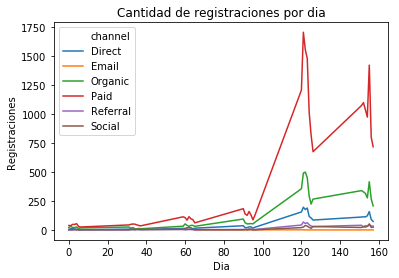

In [45]:
canales_usuarios_nuevos = datos.loc[datos['new_vs_returning'] == 'New']
canales_usuarios_nuevos = canales_usuarios_nuevos[['person','timestamp','channel']]
dias_por_mes = [False,0,31,59,90,120,151]
canales_usuarios_nuevos['timestamp'] = pd.to_datetime(canales_usuarios_nuevos['timestamp'])
canales_usuarios_nuevos ['Mes'] = canales_usuarios_nuevos['timestamp'].dt.month
canales_usuarios_nuevos ['Dia'] = canales_usuarios_nuevos['timestamp'].dt.dayofweek
canales_usuarios_nuevos['Mes'] = canales_usuarios_nuevos['Mes'].apply(lambda x: dias_por_mes[x])
canales_usuarios_nuevos['Dia'] = canales_usuarios_nuevos['Dia'] + canales_usuarios_nuevos['Mes']
canales_usuarios_nuevos['Registraciones'] = 0
canales_usuarios_nuevos = canales_usuarios_nuevos.groupby(['channel','Dia'])['Registraciones']\
                                                                                            .count().reset_index()
canales_usuarios_nuevos = canales_usuarios_nuevos.loc[canales_usuarios_nuevos['channel'] != 'Unknown']
sns.lineplot(x='Dia',y='Registraciones',hue='channel',data=canales_usuarios_nuevos)\
                                                                .set_title("Cantidad de registraciones por dia")


### 10. Eventos de los no usuarios

In [28]:
# Tomamos la fecha del primer regreso a la página
regreso = datos.loc[datos['new_vs_returning'] == 'Returning']
primer_regreso = regreso.sort_values('timestamp',ascending=True).drop_duplicates('person')
usuarios_primer_regreso = primer_regreso[['person','timestamp']]
usuarios_primer_regreso.rename(columns={'timestamp':'fecha_primer_regreso'},inplace=True)
usuarios_primer_regreso.head(5)

,person,fecha_primer_regreso
543842,8b6dbd1d,2018-01-01 12:40:21
644817,a51a7fa8,2018-01-02 15:59:53
571679,9250d410,2018-01-02 19:45:05
41369,0b9456e3,2018-01-02 20:40:38
796576,cbaee231,2018-01-03 03:59:38


In [29]:
# Mergeamos las fechas
usuarios_nuevos = pd.merge(usuarios_nuevos,usuarios_primer_regreso,on='person',how='left')
usuarios_nuevos.head(5)

,person,fecha_registro,fecha_primer_regreso
0,0004b0a2,2018-05-31 23:38:05,NaN
1,0006a21a,2018-05-29 13:29:26,NaN
2,000a54b2,2018-04-09 20:12:31,2018-05-24 11:21:07
3,00184bf9,2018-04-06 05:12:05,2018-05-04 18:47:03
4,0019c395,2018-05-17 00:08:56,NaN


In [30]:
# Tomamos los id de las personas que no se volvieron a logear
usuarios_nuevos.fillna('empty',inplace=True)
usuarios_casuales = usuarios_nuevos.loc[usuarios_nuevos['fecha_primer_regreso']=='empty']
usuarios_casuales.drop(columns=['fecha_registro','fecha_primer_regreso'],inplace=True)

In [31]:
#Agregamos las fechas al dataframe datos
datos_fechas_importantes = pd.merge(datos,usuarios_nuevos,on='person',how='inner')


In [32]:
# Nos quedamos con los eventos previos a la fecha de registro.
primeros_pasos = datos_fechas_importantes.loc[datos_fechas_importantes['timestamp']\
                                              <=datos_fechas_importantes['fecha_registro']]
# Sacamos los visited site que significan registros nuevos. Se pierden cerca de 3000 usuarios,
# que no poseen información de los eventos previos al registro.
# No se hizo en el paso anterior porque hay eventos que comparten la misma hora que la fecha de registro.
primeros_pasos = primeros_pasos.loc[primeros_pasos['new_vs_returning'] != 'New']
us = primeros_pasos.drop_duplicates('person')
print("Usuarios con eventos previos al registro: ",us.person.count(),"\n")
print("Usuarios totales: ",usuarios_nuevos.person.count())

Usuarios con eventos previos al registro:  24022 

Usuarios totales:  26898


Text(0,0.5,'Eventos')

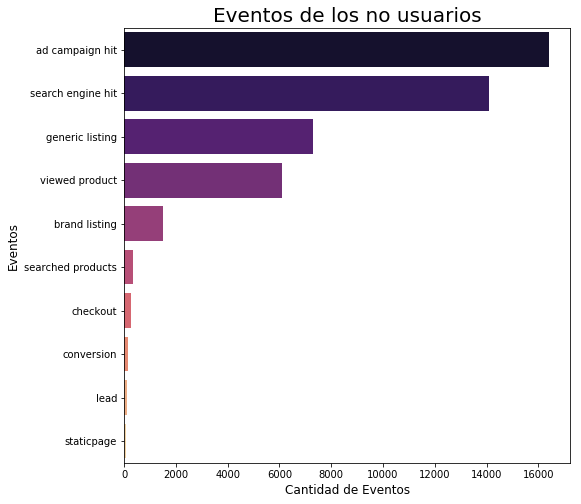

In [33]:
top_eventos=primeros_pasos['event'].value_counts()
plt.subplots(figsize=(8,8))
grafico_top_avisos=sns.barplot(x=top_eventos.values,y=top_eventos.index,orient='h',palette="magma")
grafico_top_avisos.set_title("Eventos de los no usuarios",fontsize=20)
grafico_top_avisos.set_xlabel("Cantidad de Eventos",fontsize=12)
grafico_top_avisos.set_ylabel("Eventos",fontsize=12)

##### Las campañas de avisos online y los buscadores son los principales eventos de los no registrados a la web.

In [42]:
# Eliminamos los eventos repetidos de cada persona
# Los eventos quedaran ordenados por tiempo de aparición

primeros_pasos = primeros_pasos.sort_values(by=['timestamp'],ascending=True)
primeros_pasos_eventos = primeros_pasos[['person','event']]

# Creamos un diccionario del estilo {persona:[eventos_realizados]}
dic_person_event = {}
for index, row in primeros_eventos.iterrows():
    evento = row['event']
    persona = row['person']
    if (persona not in dic_person_event):
        dic_person_event[persona] = [evento]
    else:
        #if (evento not in dic_person_event[persona]):
            dic_person_event[persona].append(evento)

In [43]:
# Iteramos sobre el diccionario, armando otro con la cantidad de apariciones de cada combinación de eventos
dic_eventos = {}
for id in dic_person_event:
    eventos = dic_person_event[id]
    evento = ' | '.join(eventos)
    if (evento not in dic_eventos):
        dic_eventos[evento] = 1
    else:
        dic_eventos[evento] += 1

df_eventos = pd.DataFrame(list(dic_eventos.items()), columns=['eventos','cantidad'])
df_eventos = df_eventos.sort_values(by=['cantidad'], ascending=False).reset_index()
df_eventos = df_eventos[['eventos', 'cantidad']]

#### Trace de los eventos de los no registrados antes de ser hacerse nuevos usuarios

In [44]:
print('Total : ',df_eventos.cantidad.sum())
df_eventos['porcentage'] = df_eventos['cantidad'] / df_eventos.cantidad.sum() * 100
df_eventos.head(10)

Total :  24022


,eventos,cantidad,porcentage
0,ad campaign hit,4410,18.358172
1,search engine hit,2590,10.781783
2,ad campaign hit | search engine hit,1747,7.272500
3,search engine hit | ad campaign hit,1737,7.230872
4,viewed product | ad campaign hit,1299,5.407543
5,ad campaign hit | viewed product,1282,5.336775
6,generic listing,1272,5.295146
7,generic listing | search engine hit,1210,5.037049
8,search engine hit | generic listing,1071,4.458413
9,generic listing | search engine hit | ad campa...,530,2.206311


##### Observamos que aproximadamente un %18 de los usuarios se registra directamente luego de entrar a la página por una campaña de marketing y el %10  luego de haber entrado por el buscador

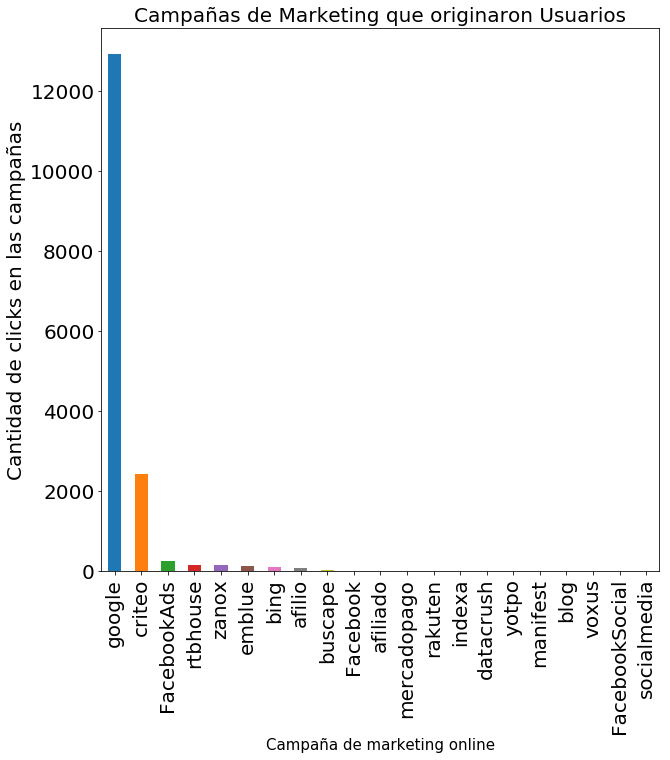

In [37]:
values = primeros_pasos.loc[primeros_pasos['event'] == 'ad campaign hit']
values['campaign_source'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Campaña de marketing online', fontsize=15);
plt.ylabel('Cantidad de clicks en las campañas', fontsize=20)
plt.title('Campañas de Marketing que originaron Usuarios', fontsize=20);

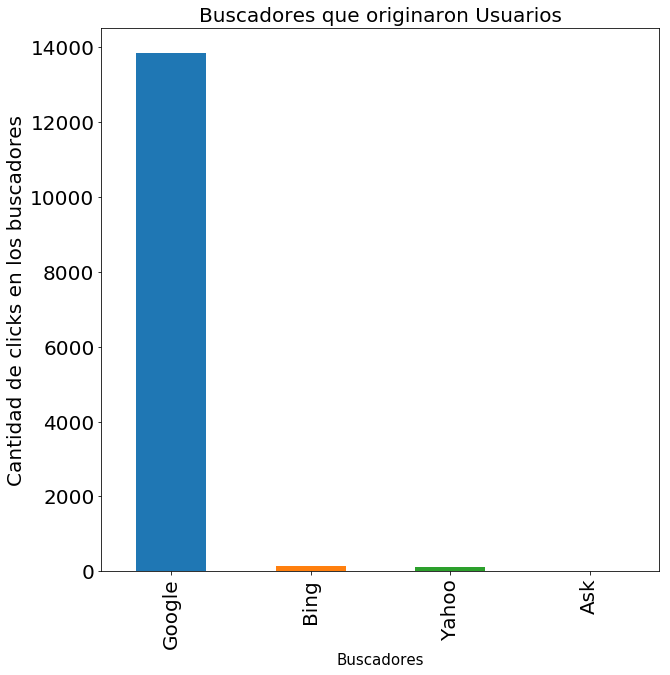

In [38]:
values = primeros_pasos.loc[primeros_pasos['event'] == 'search engine hit']
values['search_engine'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Buscadores', fontsize=15);
plt.ylabel('Cantidad de clicks en los buscadores', fontsize=20)
plt.title('Buscadores que originaron Usuarios', fontsize=20);

##### Se puede observar que las campañas marketing de Google y su buscador fue lo más predominante para la generación de usuarios. También se puede destacar Criteo como campaña de marketing.

### 11. Primer sesión de los usuarios activos y casuales

In [39]:
#Nos quedamos con la primer sesion de los usuarios activos y casuales luego del registro en la web
primer_sesion = datos_fechas_importantes.loc[(datos_fechas_importantes['timestamp']>datos_fechas_importantes['fecha_registro'])\
                                            & ( (datos_fechas_importantes['timestamp']<datos_fechas_importantes['fecha_primer_regreso'])\
                                              | (datos_fechas_importantes['fecha_primer_regreso'] == 'empty') )]
primer_sesion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267472 entries, 2 to 1008789
Data columns (total 25 columns):
timestamp                   267472 non-null object
event                       267472 non-null object
person                      267472 non-null object
url                         15174 non-null object
sku                         175334 non-null float64
model                       175367 non-null object
condition                   175334 non-null object
storage                     175334 non-null object
color                       175334 non-null object
skus                        65417 non-null object
search_term                 16450 non-null object
staticpage                  726 non-null object
campaign_source             15183 non-null object
search_engine               10664 non-null object
channel                     0 non-null object
new_vs_returning            0 non-null object
city                        0 non-null object
region                      0 non-null obje

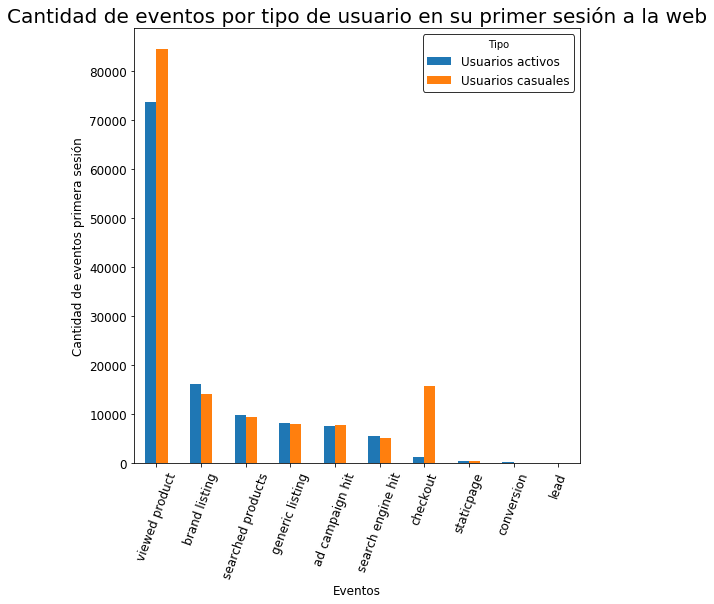

In [40]:
primer_nuevos_casuales = primer_sesion[['event','person','fecha_primer_regreso']]
primer_nuevos_casuales.rename(columns={'fecha_primer_regreso':'user_type'},inplace=True)
primer_nuevos_casuales.loc[(primer_nuevos_casuales['user_type'] != 'empty'),'user_type'] = 'Usuario Activo'
primer_nuevos_casuales.loc[(primer_nuevos_casuales['user_type'] == 'empty'),'user_type'] = 'Usuario Casual'

primer_nuevos_casuales['person'] = 1
table = primer_nuevos_casuales.pivot_table(index='event',columns='user_type',aggfunc=np.sum)
table.columns = table.columns.droplevel(0)
table.reset_index(level=[0],inplace=True)
table = table.sort_values('Usuario Activo',ascending=False)
grafico_comp_post_vista=table.plot(kind='bar',x='event',fontsize=12,figsize=(8,8),rot=70)
grafico_comp_post_vista.set_title("Cantidad de eventos por tipo de usuario en su primer sesión a la web",fontsize=20)
grafico_comp_post_vista.set_xlabel("Eventos",fontsize=12)
grafico_comp_post_vista.set_ylabel("Cantidad de eventos primera sesión",fontsize=12)
leyenda=plt.legend(['Usuarios activos','Usuarios casuales'],fontsize=12,title='Tipo',frameon=True,facecolor='white',edgecolor='black')
leyenda.get_frame().set_linewidth(1.0)

##### Podemos notar una similitud en los eventos de ambos tipos de usuarios, con excepción del checkout, dónde predominan los usuarios con solo una sesión. Esto no influye en la compra de productos, ya que los usuarios 'activos' tienen mayor conversión, aunque se puede notar que en su primer sesión hay una muy pobre cantidad de conversiones.

### 12. Términos más utilizados en las búsquedas

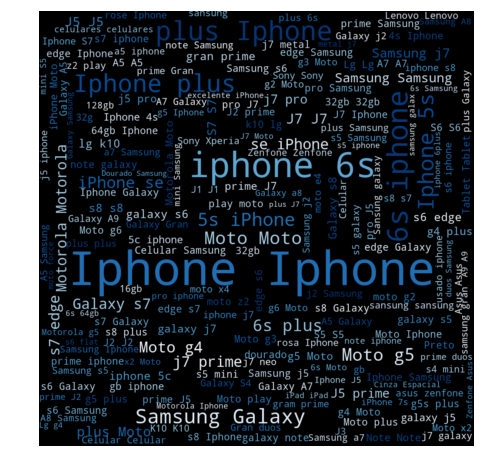

In [41]:
words = datos['search_term'].dropna()
words = ' '.join(words)

plt.subplots(figsize=(8,8))
wordcloud = WordCloud(width=1000,height=1000, margin=0,colormap="Blues").generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


##### Observamos que lo más buscado es la marca de celulares de Apple, sobre todo los modelos 5s y 6s. En menor medida se busca marcas Samsung y Motorola.

### 13. Relacion entre los eventos

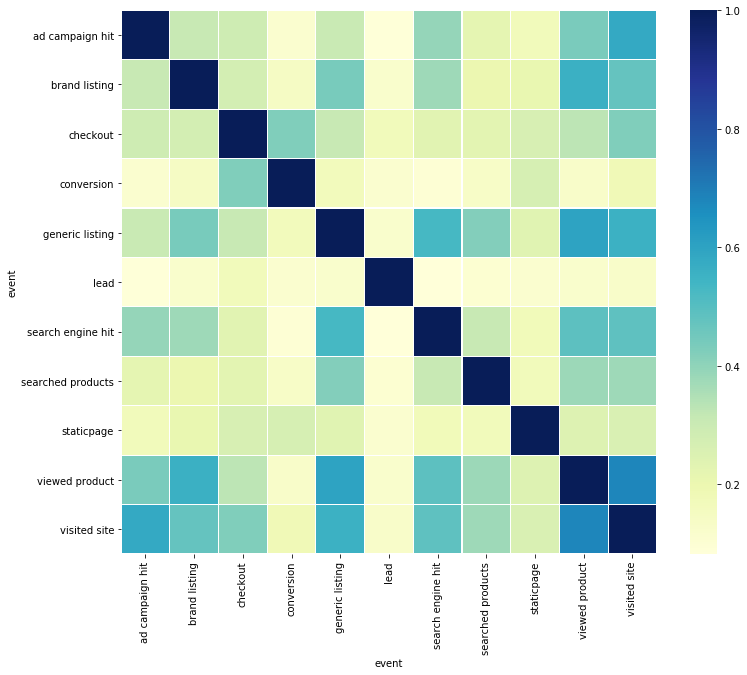

In [46]:
eventos_x_person = datos[['person','event','timestamp']]
eventos_x_person = eventos_x_person.groupby(['person','event']).agg({'timestamp':'count'})
eventos_x_person = eventos_x_person.unstack(-1)
eventos_x_person.columns = eventos_x_person.columns.droplevel(0)
eventos_x_person = eventos_x_person.reset_index(level=0,drop=False)
eventos_x_person = eventos_x_person.fillna(0)
corrmat = eventos_x_person.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)